In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from jaynes_cummings_model import *
from embedding import Embedding

Jaynes-Cummings model with damping: 
$$
\frac{d \rho}{dt} = -i [ H_{JC}, \rho] + \gamma(a \rho a^{\dagger} - \frac{1}{2}a^{\dagger} a \rho - \frac{1}{2}\rho a^{\dagger} a )
$$
Where 
$$
H_{JC} = (\alpha_x X + \alpha_y Y + \alpha_z Z) \otimes 1 + 1 \otimes a^{
\dagger} a + \Omega \left(\frac{X +iY}{2} \otimes a + h.c.\right)
$$

In [3]:
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0, -1j], [1j, 0]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

pauli = tf.concat([sigma_x[tf.newaxis], sigma_y[tf.newaxis], sigma_z[tf.newaxis]], axis=0)

In [4]:
# Parameters 
# simulation_parameters
total_time = 20
time_step = 0.1
number_of_lines = 2
# system_parameters
omega, gamma = 10., 0.05
alpha = tf.constant([1., 0., 1.], dtype=tf.complex128)
sys_dim = 2
mode_type = 'Coherent_state'
mode_parameter = 1.1

System dimention =  2
Environmet dimention =  5
Mode type =  Coherent_state 
Mode parameter =  1.1


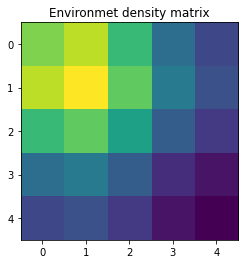

In [5]:
model = JC_model(sys_dim, mode_type, mode_parameter)
print('System dimention = ', model.sys_dim)
print('Environmet dimention = ', model.env_dim)
print('Mode type = ', model.mode_type, '\nMode parameter = ', model.mode_par)

plt.title('Environmet density matrix')
plt.imshow(np.real(model.env_state))

In [6]:
model.lindblad_generator(alpha, omega, gamma)
tf.shape(model.generator)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([100, 100], dtype=int32)>

In [7]:
model.generate_dynamics(2 * number_of_lines, total_time, time_step)
tf.shape(model.dynamics)

100%|██████████| 200/200 [00:03<00:00, 63.44it/s]


<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  4, 200,   2,   2], dtype=int32)>

In [8]:
data_train = model.dynamics[:number_of_lines]
data_test = model.dynamics[number_of_lines:]

In [9]:
train_set = tf.tensordot(data_train, pauli, [[2, 3], [2, 1]])
test_set = tf.tensordot(data_test, pauli, [[2, 3], [2, 1]])

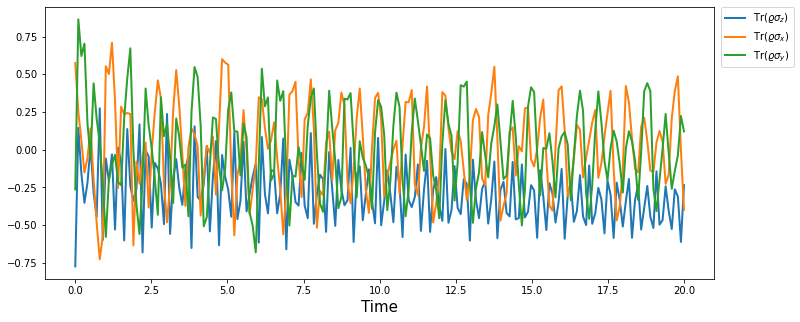

In [10]:
time = tf.linspace(0, total_time, train_set.shape[1])
plt.figure(figsize=(12, 5))
plt.plot(time, np.real(train_set[0, :, 2]),
         label = r'${\rm Tr}(\varrho \sigma_z)$',
         color='tab:blue', 
         linewidth = 2)
plt.plot(time, np.real(train_set[0, :, 0]),
         label = r'${\rm Tr}(\varrho \sigma_x)$',
         color='tab:orange',
         linewidth = 2)
plt.plot(time, np.real(train_set[0, :, 1]),
         label = r'${\rm Tr}(\varrho \sigma_y)$',
         color='tab:green',
         linewidth = 2)
plt.xlabel('Time', fontsize=15)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)



In [14]:
eps = 1e-3  # tolerance
K =70

ind=0

# embedding
emb = Embedding()
emb.learn(data_train, eps=eps, K=K, denoise=False)
min_rank = emb.rank

K = emb.K
prediction = emb.predict(data_test[ind, :K],
                         data_test.shape[1])
# corresponding bloch vectors
X_predicted = tf.tensordot(prediction, pauli, [[1, 2], [2, 1]])
# test bloch vectors
X_test = tf.tensordot(data_test, pauli, [[2, 3], [2, 1]])

Minimal Rank =  34
True Rank =  100


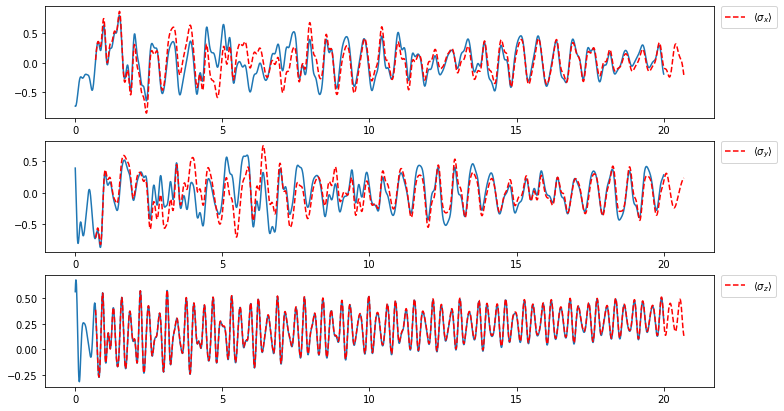

In [15]:
time = tf.linspace(0, total_time, X_test.shape[1])
plt.figure(figsize=(12, 7))

plt.subplot(311)
plt.plot(time, np.real(X_test[ind, :, 0]),
         color='tab:blue')
plt.plot(time + (K - 1) * time_step, np.real(X_predicted[:, 0]),
         'r--', label=r'$\langle\sigma_x\rangle$')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.subplot(312)
plt.plot(time, np.real(X_test[ind, :, 1]),
         color='tab:blue')
plt.plot(time + (K - 1) * time_step, np.real(X_predicted[:, 1]),
         'r--', label=r'$\langle\sigma_y\rangle$')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.subplot(313)
plt.plot(time, np.real(X_test[ind, :, 2]), 
         color='tab:blue')
plt.plot(time + (K - 1) * time_step, np.real(X_predicted[:, 2]),
         'r--', label=r'$\langle\sigma_z\rangle$')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

print('Minimal Rank = ', min_rank)
print('True Rank = ', (model.sys_dim * model.env_dim)**2)